# HW2

## GENERAL INSTRUCTIONS:

- CLEARLY mark where you are answering each question (all questions must be answered in Markdown cells, NOT as comments in code cells)
- Show all code necessary for the analysis, but remove superfluous code

---

Use the [Loan Dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv) on GitHub to build the classification models described below.

## Variable Descriptions:
- `age`: age in years of person.
- `had_cancer`: 0 if the person has NOT had cancer or has cancer, 1 if they have.
- `gender_id`: `Male`, `Female`, `Non-Binary`, or `Survey Choices Do Not Accurately Reflect My Identity`.
- `income_in_k`: income in thousands of dollars.
- `state`: state person lives in.
- `credit_score`: credit score.
- `num_credit_sources`: number of sources of credit (includes credit cards, loans, car payments...etc).
- `utilization_rate`: the % of a person's total credit they use on average each month. For example if you have 10,000 dollars in available credit, and use 2,000 your utilization rate would be 0.2 (20%).
- `gave_loan`: whether or not the person got a loan.

## Instructions
1. *Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan (total of 3 models).*
    - If a variable/predictor has more than 2 categories, use `get_dummies()` to convert them into dummy variables (don't forget to remove the original column when training!).
    - Use the KFold() function with 5 folds (use the same KF for-loop to fit all three models, i.e. there should only be one KFold loop where you fit 3 models)
    - Z-score your continuous variables only (interval data like age...etc can be counted as continuous)
    - For KNN, include only *continuous/interval* columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than `gave_loan`).
    - For KNN, choose K by using grid search.
    - For Decision Trees, use grid search to choose max_depth, and check for overfitting.
    - Record the Train/Test accuracies, and print out confusion matrices.
    
    
    
2. *Evaluate Your Models (ANSWER IN MARKDOWN CELL)*
    - A) Using accuracy and confusion matrices, **which model did best, how can you tell?**
    - B) **Are there differences in how well the three models you made in part 1 do for different gender IDs? (do not make new models, use the models from before)**
    - C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? What are the possible implications of this**

In [175]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn import metrics 

from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%precision %.7g
%matplotlib inline

In [176]:
# importing data
loanDF = pd.read_csv("/Users/iman/CPSC_Courses/CPSC392ParlettPelleriti/Data/HW2.csv")
loanDF.head()

,age,had_cancer,gender_id,income_in_k,state,credit_score,num_credit_sources,utilization_rate,gave_loan
0,39,0,Female,54,TX,448,4,0.32,0
1,43,0,Female,66,NJ,399,4,0.35,0
2,42,0,Male,50,NE,509,8,0.23,0
3,46,0,Female,79,TX,540,6,0.15,0
4,43,0,Female,49,NV,485,10,0.20,0


## 1. Build a *KNN*, *Decision Tree*, AND *Logistic Regression model* to predict whether or not someone got a loan (total of 3 models).

### If a variable/predictor has more than 2 categories, use `get_dummies()` to convert them into dummy variables (don't forget to remove the original column when training!).

In [177]:
# make gender identity and state columns
genderIdDummies = pd.get_dummies(loanDF["gender_id"])
stateDummies = pd.get_dummies(loanDF["state"])

loanDF = pd.concat([loanDF,genderIdDummies], axis = 1) 
loanDF = pd.concat([loanDF,stateDummies], axis = 1) 

# show the new columns that were added
loanDF.head()

,age,had_cancer,gender_id,income_in_k,state,credit_score,num_credit_sources,utilization_rate,gave_loan,Female,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,39,0,Female,54,TX,448,4,0.32,0,1,...,0,0,1,0,0,0,0,0,0,0
1,43,0,Female,66,NJ,399,4,0.35,0,1,...,0,0,0,0,0,0,0,0,0,0
2,42,0,Male,50,NE,509,8,0.23,0,0,...,0,0,0,0,0,0,0,0,0,0
3,46,0,Female,79,TX,540,6,0.15,0,1,...,0,0,1,0,0,0,0,0,0,0
4,43,0,Female,49,NV,485,10,0.20,0,1,...,0,0,0,0,0,0,0,0,0,0


In [178]:
# calculate values for evaluating values

# remove gender_id and state column 
del loanDF["gender_id"]
del loanDF["state"]

# show new dataframe where the original gender_id and state columns are gone 
loanDF.head()

,age,had_cancer,income_in_k,credit_score,num_credit_sources,utilization_rate,gave_loan,Female,Male,Non-Binary,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,39,0,54,448,4,0.32,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,43,0,66,399,4,0.35,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42,0,50,509,8,0.23,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,46,0,79,540,6,0.15,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,43,0,49,485,10,0.20,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Use KFold with 5 folds (use the same KF loop to fit all three models)

In [180]:
# predictor values
allLoanPred = ['age', 'had_cancer', 'income_in_k', 'credit_score',
       'num_credit_sources', 'utilization_rate', 'Female', 'Male',
       'Non-Binary', 'Survey Choices Do Not Accurately Reflect My Identity',
       'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY']

# list of only continuous variables
contPred = ['age', 'income_in_k', 'credit_score', 'num_credit_sources', 
       'utilization_rate']

# store all loan predictors allXVals
allX = loanDF[allLoanPred]

# store continuous predictors and outcomes in continuousX and y variables
contX = loanDF[contPred]
y = loanDF["gave_loan"]

# create empty kfold object
# set argument n_splits to be 5
    # this is so it can use 80% of our data
kf = KFold(n_splits = 5, shuffle = True)
kf.split(allX)

# Logistic Regression accuracy lists
# create empty lists to store accuracy for each fold of training and test set for log reg
trainAccLogisticRegression = []
testAccLogisticRegression = []

# Decision Tree accuracy lists
# create empty lists to store accuracy for each fold of training and test set and model 
       # accuracy and depth for decision tree
trainAccDecisionTree = []
testAccDecisionTree = []
modelAccDecisionTree = []
depth = []

# KNN accuracy lists
# create empty lists to store train and test set accuracy for KNN 
trainAccKNN = []
testAccKNN = []

# create log reg model
loanLogModel = LogisticRegression() 

## Use KFold with 5 folds (use the same KF loop to fit all three models)
## Z-score your continuous variables only (interval data like age...etc can be counted as continuous)
## For KNN, include only *continuous/interval* columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than `gave_loan`).
## For KNN, choose K by using grid search.
## For Decision Trees, set the `max_depth` if overfitting.
## Record the Train/Test accuracies, and print out confusion matrices.

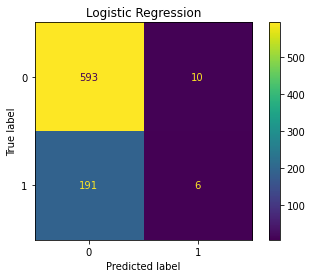

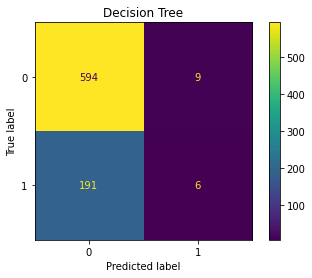

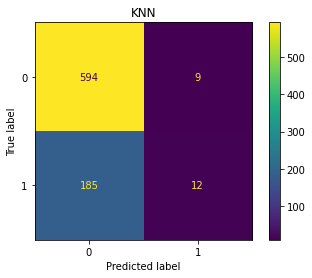

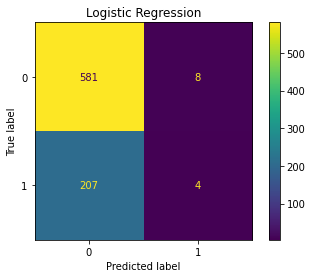

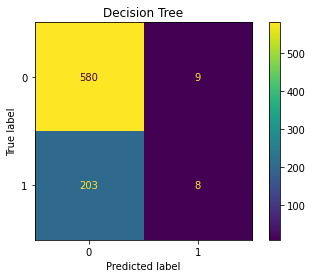

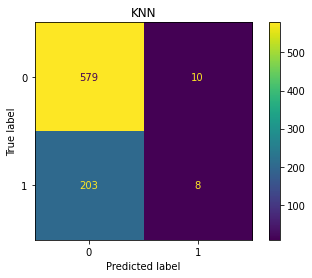

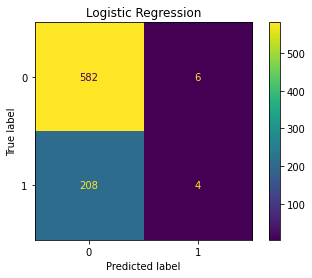

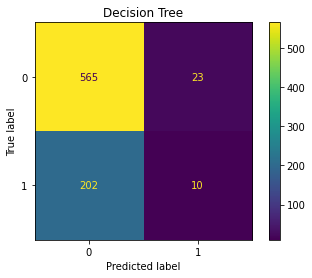

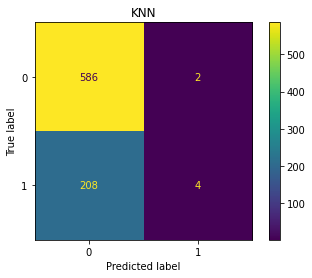

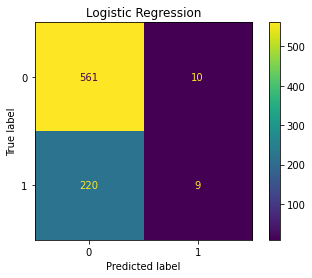

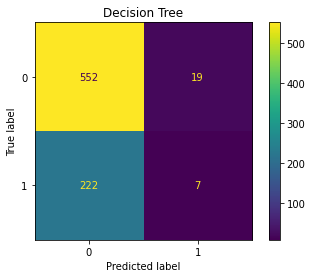

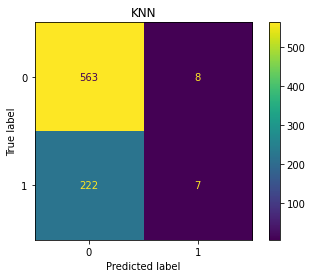

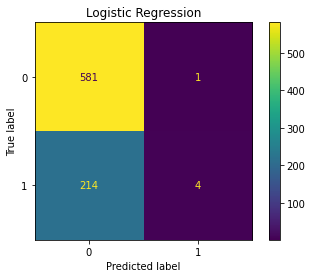

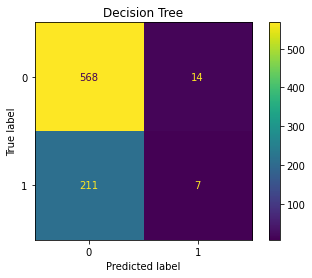

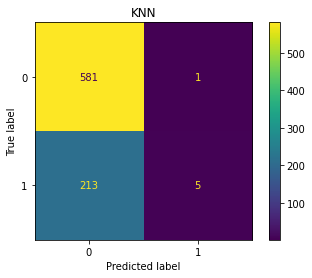

In [185]:
# Use KFold with 5 folds (use the same KF loop to fit all three models)

# for loop that will loop through each of the models we will create
# the train and test that are referenced in the for loop are the indices of the rows that are
    # going to be our training set and the rows that will be in our testing set respecively

for train_indices, test_indices in kf.split(allX,y):
    X_train = allX.iloc[train_indices]
    X_test  = allX.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test  = y.iloc[test_indices]

    #############

    # Logistic Regression

    # Z-score your continuous variables only
    # preprocessing by z-scoring
    # avoid data leakage bc if we z-score incorrectly, it can cause info from test set to leak into model
    zscore = StandardScaler()

    # ONLY FIT ON TRAINING SET
    # transform train and test set to get the actual z-score 
    Xz_train = zscore.fit_transform(X_train[contPred])
    Xz_test = zscore.transform(X_test[contPred])

    X_train[contPred] = Xz_train
    X_test[contPred] = Xz_test

    # For Logistic Regression use ALL columns as predictors

    # log reg model
    logRegFitModel = loanLogModel.fit(X_train, y_train)

    # Record the Train/Test accuracies
    trainAccLogisticRegression.append(accuracy_score(y_train, logRegFitModel.predict(X_train)))
    testAccLogisticRegression.append(accuracy_score(y_test, logRegFitModel.predict(X_test)))  

    # Print out confusion matrices
    # log reg confusion matrix
    plot_confusion_matrix(loanLogModel, X_test, y_test).ax_.set_title("Logistic Regression")

    #############

    # Decision Tree

    # For Decision Trees, set the max_depth if overfitting

    # decision tree model    
    tree = DecisionTreeClassifier(max_depth = 5)

    # For Decision Tree use ALL columns as predictors

    # fitting tree model 
    treeModelFit = tree.fit(X_train,y_train)

    modelAccDecisionTree.append(treeModelFit.score(X_test,y_test))
    depth.append(treeModelFit.get_depth())

    # Record the Train/Test accuracies
    trainAccDecisionTree = accuracy_score(y_train,treeModelFit.predict(X_train))
    testAccDecisionTree = accuracy_score(y_test,treeModelFit.predict(X_test))

    # Print out confusion matrices
    # decision tree confusion matrix
    plot_confusion_matrix(treeModelFit, X_test, y_test).ax_.set_title("Decision Tree")

    #############
    
    # KNN

    # For KNN, choose K by using grid search

    # knn model grid search
    knnGridSearch = KNeighborsClassifier()
    # choose potential values of k (ranges from 1 to 30)
    ks = {"n_neighbors": range(1,30)}
    # use grid search to find best parameters
    grid = GridSearchCV(knnGridSearch,ks, scoring = "accuracy", cv = 5)
    knnmod = grid.fit(X_train, y_train)
    n_neighbors = knnmod.best_estimator_.get_params()["n_neighbors"]

    # knn model
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)

    # preprocessing by z-scoring
    z = StandardScaler()

    # only continuous X values
    X_train_cont = X_train[contPred]
    X_test_cont = X_test[contPred]

    # z-scoring variables
    Xz_train_cont = z.fit_transform(X_train_cont)
    # NEVER REFIT ON TEST SET, ONLY TRANSFORM
    Xz_test_cont = z.transform(X_test_cont)

    # For KNN, include only continuous/interval columns as predictors

    # fitting knn model 
    knnModelFit = knn.fit(Xz_train_cont,y_train)
    
    # Record the Train/Test accuracies
    trainAccKNN = accuracy_score(y_train,knnModelFit.predict(Xz_train_cont))
    testAccKNN = accuracy_score(y_test,knnModelFit.predict(Xz_test_cont))

    # Print out confusion matrices
    # KNN confusion matrix
    plot_confusion_matrix(knnModelFit, Xz_test_cont, y_test).ax_.set_title("KNN")

    #############

    

In [35]:
# logistic regression test/train accuracy
print("Logistic Regression Train Accuracy", np.mean(trainAccLogisticRegression))
print("Logistic Regression Test Accuracy", np.mean(testAccLogisticRegression))

Logistic Regression Train Accuracy 0.7348750000000001
Logistic Regression Test Accuracy 0.73275


In [36]:
# decision tree test/train accuracy
print("Decision Tree Train Accuracy", np.mean(trainAccDecisionTree))
print("Decision Tree Test Accuracy",np.mean(testAccDecisionTree))

Decision Tree Train Accuracy 0.750625
Decision Tree Test Accuracy 0.715


In [37]:
print("Decision Tree Model Accuracy", np.mean(modelAccDecisionTree))
print("Decision Tree depth", np.mean(depth))

Decision Tree Model Accuracy 0.71875
Decision Tree depth 5.0


In [38]:
# knn test+train accuracy 
print("KNN Train Accuracy", np.mean(trainAccKNN))
print("KNN Train Accuracy", np.mean(testAccKNN))

KNN Train Accuracy 0.739375
KNN Train Accuracy 0.73375


# 2. Evaluate Your Models

## A) Using accuracy and confusion matrices, which model did best, how can you tell?

All 3 mdoels performed quite similarly to each other based on each of their accuracy scores. They performed in the range of 0.715 to 0.735 which is pretty good, but could be better. Since the accuracy scores for the test and train sets for all 3 models are similar, there is not really one model that can be considered the best compared to the other models. 

Even the confusion matrices for all 3 models are quite similar because in all 3 models, it is making alot more errors predicting a person has not gotten a loan when they have. It is also predicting whether a person has not gotten a loan more and rarely predicting when they have gotten a loan. This type of prediction is creating an imbalance on the off diagonal. Our models would be performing much better if it was making more accurate predictions when the predicted value is 1 (meaning the person has gotten a loan), and the true value would also be 1. Same goes for when predciting a person hasn't gotten a loan, and correspondinly more of the true values of the predictions will also be 0 (a person hasn't gotten a loan). However, when looking at the confusion matrix, we can see that the model can accurately predict for when a person hasn't gotten a loan, but is less accurate when it comes to predicting if a person has gotten a loan.

If we had to pick the best model, it would probably be logistic regression and KNN because their train set accuracy was the closest to their test set accuracies. Meaning, they were the least overfit. Because the decision tree's train accuracy was 0.750625 and test accuracy was 0.715, it was more overfit that the other 2 models. This means that the model is too atuned to the training set's data and is not equipped to accurately predict values for unseen data.

All of the models have test accuracies that range from 0.715 to 0.735, which tells us that the model is not performing too well, but also not too poorly. This may be due to maybe these 3 models not being the best models to train on this data set. However, these models might not be performing too poorly either because all 3 are not too overfit, so it does perform well when introduced to new unseen data.

## B) Are there differences in how well the three models you made in part 1 do for different gender IDs? (do not make new models, use the models from before)

In [186]:
# z-scoring continuous variables
zsLogPred = zscore.transform(loanDF[contPred])

# replacing the previous continuous variables with z-scored data in loan data frame
loanDF[contPred] = zsLogPred

# For KNN, include only continuous/interval columns as predictors
# For Decision Tree and Logistic Regression use ALL columns
# using z-scored data for log reg bc we trained on z-scored variables
logisticRegressionPreds = logRegFitModel.predict(loanDF[allLoanPred]) 
decisionTreePreds = treeModelFit.predict(loanDF[allLoanPred]) 
knnPreds = knnModelFit.predict(loanDF[contPred])

loanDF["Logistic Regression Predicted Values"] = logisticRegressionPreds
loanDF["Decision Tree Predicted Values"] = decisionTreePreds
loanDF["KNN Predicted Values"] = knnPreds

In [187]:
# Logistic Regression Gender ID

maleLogReg = loanDF.loc[loanDF["Male"] == 1]
maleLogRegAcc = accuracy_score(maleLogReg["gave_loan"], maleLogReg["Logistic Regression Predicted Values"])
print("Male Logistic Regression Accuracy Score: ", maleLogRegAcc)

femaleLogReg = loanDF.loc[loanDF["Female"] == 1]
femaleLogRegAcc = accuracy_score(femaleLogReg["gave_loan"], femaleLogReg["Logistic Regression Predicted Values"])
print("Female Logistic Regression Accuracy Score: ", femaleLogRegAcc)

nonBinaryLogReg = loanDF.loc[loanDF["Non-Binary"] == 1]
nonBinaryLogRegAcc = accuracy_score(nonBinaryLogReg["gave_loan"], nonBinaryLogReg["Logistic Regression Predicted Values"])
print("Non Binary Logistic Regression Accuracy Score: ", nonBinaryLogRegAcc)

surveyLogReg = loanDF.loc[loanDF["Survey Choices Do Not Accurately Reflect My Identity"] == 1]
surveyLogRegAcc = accuracy_score(surveyLogReg["gave_loan"], surveyLogReg["Logistic Regression Predicted Values"])
print("Survey Choices Do Not Accurately Reflect My Identity Logistic Regression Accuracy Score: ", surveyLogRegAcc)

Male Logistic Regression Accuracy Score:  0.7228464419475655
Female Logistic Regression Accuracy Score:  0.7405590975968612
Non Binary Logistic Regression Accuracy Score:  0.7678571428571429
Survey Choices Do Not Accurately Reflect My Identity Logistic Regression Accuracy Score:  0.8055555555555556


In [169]:
# Decision Tree Gender ID

maleTree = loanDF.loc[loanDF["Male"] == 1]
maleTreeAcc = accuracy_score(maleTree["gave_loan"], maleTree["Decision Tree Predicted Values"])
print("Male Decision Tree Accuracy Score: ", maleTreeAcc)

femaleTree = loanDF.loc[loanDF["Female"] == 1]
femaleTreeAcc = accuracy_score(femaleTree["gave_loan"], femaleTree["Decision Tree Predicted Values"])
print("Female Decision Tree Accuracy Score: ", femaleTreeAcc)

nonBinaryTree = loanDF.loc[loanDF["Non-Binary"] == 1]
nonBinaryTreeAcc = accuracy_score(nonBinaryTree["gave_loan"], nonBinaryTree["Decision Tree Predicted Values"])
print("Non Binary Decision Tree Accuracy Score: ", nonBinaryTreeAcc)

surveyTree = loanDF.loc[loanDF["Survey Choices Do Not Accurately Reflect My Identity"] == 1]
surveyTreeAcc = accuracy_score(surveyTree["gave_loan"], surveyTree["Decision Tree Predicted Values"])
print("Survey Choices Do Not Accurately Reflect My Identity Decision Tree Accuracy Score: ", surveyTreeAcc)

Male Decision Tree Accuracy Score:  0.7228464419475655
Female Decision Tree Accuracy Score:  0.7405590975968612
Non Binary Decision Tree Accuracy Score:  0.7678571428571429
Survey Choices Do Not Accurately Reflect My Identity Decision Tree Accuracy Score:  0.8055555555555556


In [170]:
# KNN Gender ID

maleKNN = loanDF.loc[loanDF["Male"] == 1]
maleKNNAcc = accuracy_score(maleKNN["gave_loan"], maleKNN["KNN Predicted Values"])
print("Male Decision Tree Accuracy Score: ", maleKNNAcc)

femaleKNN = loanDF.loc[loanDF["Female"] == 1]
femaleKNNAcc = accuracy_score(femaleKNN["gave_loan"], femaleKNN["KNN Predicted Values"])
print("Female Decision Tree Accuracy Score: ", femaleKNNAcc)

nonBinaryKNN = loanDF.loc[loanDF["Non-Binary"] == 1]
nonBinaryKNNAcc = accuracy_score(nonBinaryKNN["gave_loan"], nonBinaryKNN["KNN Predicted Values"])
print("Non Binary Decision Tree Accuracy Score: ", nonBinaryKNNAcc)

surveyKNN = loanDF.loc[loanDF["Survey Choices Do Not Accurately Reflect My Identity"] == 1]
surveyKNNAcc = accuracy_score(surveyKNN["gave_loan"], surveyKNN["KNN Predicted Values"])
print("Survey Choices Do Not Accurately Reflect My Identity Decision Tree Accuracy Score: ", surveyKNNAcc)

Male Decision Tree Accuracy Score:  0.7228464419475655
Female Decision Tree Accuracy Score:  0.7405590975968612
Non Binary Decision Tree Accuracy Score:  0.7678571428571429
Survey Choices Do Not Accurately Reflect My Identity Decision Tree Accuracy Score:  0.8055555555555556


B) Are there differences in how well the three models you made in part 1 do for different gender IDs? (do not make new models, use the models from before)

There is not much difference in how well the 3 models performed. As expected, all 3 of the models performed with about the same accuracy given the different gender id's because all 3 models performed around the same with their overall accrucy scores being between 0.72 to 0.74, as we saw in Part 1. Since the accuracy scores for each of the models is within the ranges of 0.72 and 0.74, when predicting for the different gender ID's, the models would theoretically predict with about the same accuracy, which it is. 

The logistic regression, decision tree and KNN model perform much pretty high for different gender ID's ranging from accuracy scores of 0.72 to 0.81. All 3 models perform considerably well on whether a person got a loan depending on their gender id. This may be because in the case of the decision tree, since it iteratively adds layers to the tree and checks to see if the split we make on a category improves the ability to predict the right category, it will move on and coninue with the split. Doing this improves the performance of predicting what data point belongs to what category.

The logistic regression model is also performing similarly well becuase since the data was being predicted fairly well as a log model with all of the data points, the gender ID's would be following the same model graph, predicting in the same way as other data points.

In a knn model, the model assumes that if the specific data point neighbors are similar to other data points with respect to the features that we are choosing, the data point will have the same category as them. It looks at all the data points that are near the current data point based on the values of the different features. Since it operates on the assumption that if you are near other data points in the category, the model will put you in that category. Hence, the gender ID's and whether they recived or didn't recieve a loan are categorized based on their neighboring data points and their categorical features. 

Since all 3 models are more accuratly predicting for loans given to a person where the survey choices do not accurately reflect their identity (with an accuracy score of about 0.81) than the other gender ID's, the implications of this might be that for most people who do not identify with the ID's in the survey, they will get a more accurate prediction for if they got a loan or not. Meaning, they will receive better service depending on if they got a loan or didn't. However, since all 3 models also did not as well with predicting for Males and Females (with an accuracy score of about 0.72 and 0.74) as they did for the people who did not identify with the ID's in the survey, there might be some inaccuracies and biases against these 2 gender ID's. This means that they will not receive the as much of a proper service as the people who did not identify with the ID's in regards to getting a loan.

## C) Are your models better at predicting people who got loans, or didn't get loans? How can you tell? What are the possible implications of this?

Based on the confusion matrices, we can deduce that the model can accurately predict for when a person hasn't gotten a loan, but is less accurate when it comes to predicting if a person hasn't gotten a loan for all 3 models. Because all 3 models have an imbalanced off diagonal, predicting a majority of true negatives and false negatives, the model better predicts people who got loans. It is also predicting whether a person has not gotten a loan more and rarely predicting when they have gotten a loan.

The implications of this might be that the model do not perform well when it has to predict for someone who got a loan. This could also mean that the 3 models we are using on this data set isn't ideal types that we used on this data set is just not ideal